Notebook notes: this notebook is taking the microsoft segmentation specified as image_masks.pkl as seen in the filename variable and then adding it to our directory of pickle files for training.

In [1]:
%load_ext autoreload
%autoreload 2
import glob
import torch
from torch.nn import BCEWithLogitsLoss
import numpy as np
from sklearn.metrics import confusion_matrix
import torchvision
import torch.nn.functional as F
import random
from tqdm import tqdm
import argparse
from datetime import date
from PIL import Image
from torch.utils.tensorboard import SummaryWriter
import sys
sys.path.insert(0, '../utils')
from ground_truth_dataset import groundTruthDataset
from driven_dataset import drivenDataset
from data_functions import splitDataset, returnLoaders
from metrics import returnInterUnion, returnPreReF
sys.path.insert(0, '../models')
from unet_model import UNet
import matplotlib.pyplot as plt

In [2]:
from PIL import Image
import rasterio
from rasterio.plot import show
import numpy as np
import pickle
import glob
import re

In [3]:
filename = '../../../notebooks/home/data/processed/planet_images_ia-2020/image_masks.pkl'
with open(filename, 'rb') as f:
    loaded1 = pickle.load(f)

In [4]:
file_list = list(loaded1.keys())
img_prefix = '../../../notebooks/home/data/raw/planet_images_il-2020/'
save_prefix = '../../../notebooks/home/data/raw/ground_truth/'

In [7]:
file_list

['/home/dssg-reglab/notebooks/home/data/raw/planet_images_ia-2020/planet_loc_6835-date_2020-07-01.tif',
 '/home/dssg-reglab/notebooks/home/data/raw/planet_images_ia-2020/planet_loc_5646-date_2020-07-01.tif',
 '/home/dssg-reglab/notebooks/home/data/raw/planet_images_ia-2020/planet_loc_6076-date_2020-07-01.tif',
 '/home/dssg-reglab/notebooks/home/data/raw/planet_images_ia-2020/planet_loc_11752-date_2020-07-01.tif',
 '/home/dssg-reglab/notebooks/home/data/raw/planet_images_ia-2020/planet_loc_7278-date_2020-07-01.tif',
 '/home/dssg-reglab/notebooks/home/data/raw/planet_images_ia-2020/planet_loc_8800-date_2020-07-01.tif',
 '/home/dssg-reglab/notebooks/home/data/raw/planet_images_ia-2020/planet_loc_2056-date_2020-07-01.tif',
 '/home/dssg-reglab/notebooks/home/data/raw/planet_images_ia-2020/planet_loc_9083-date_2020-07-01.tif',
 '/home/dssg-reglab/notebooks/home/data/raw/planet_images_ia-2020/planet_loc_12225-date_2020-07-01.tif',
 '/home/dssg-reglab/notebooks/home/data/raw/planet_images_ia-2

# Saving masks to Pickle Files

In [ ]:
for file in file_list:    
    with rasterio.open(file) as src:
        b, g, r, n = src.read()
    rgb = np.stack((r,g,b), axis=0)    
    
    
    if np.prod(rgb[0].shape) < 400*400:    
        np_image = (np.rollaxis(rgb/rgb.max(), 0, 3)*255).astype(np.uint8)
        image = Image.fromarray((np.rollaxis(rgb/rgb.max(), 0, 3)*255).astype(np.uint8))
        mask = loaded1[file]

        toSave = {}
        toSave['image'] = image
        toSave['masks'] = {}
        toSave['masks']['CAFO Shed'] = (mask == 1).astype(np.uint8).squeeze(0)
        toSave['masks']['BACKGROUND'] = (mask == 0).astype(np.uint8).squeeze(0)
        toSave['masks']['Lagoon'] = np.zeros(mask.shape).squeeze(0)
        
        with open(save_prefix + image_name + ".p", "wb") as f:
            pickle.dump(toSave, f)    

# Checking if masks match with image

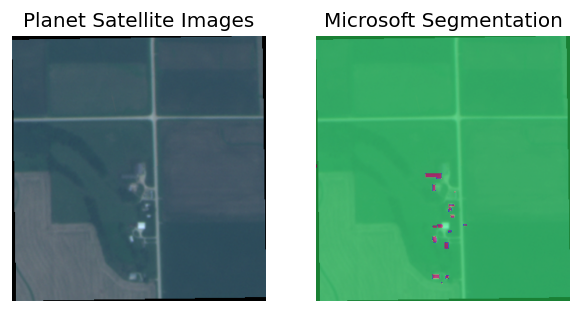

In [24]:
i = 5# which image to check
#image_name = re.search(r'(?<=ia-2020/)[A-z0-9\-]+', file_list[i]).group()
with rasterio.open(file_list[i]) as src:
    b, g, r, n = src.read()
        
rgb = np.stack((r,g,b), axis=0)

if np.prod(rgb[0].shape) < 400*400:    
    np_image = (np.rollaxis(rgb/rgb.max(), 0, 3)*255).astype(np.uint8)
    image = Image.fromarray((np.rollaxis(rgb/rgb.max(), 0, 3)*255).astype(np.uint8))
    mask = loaded1[file_list[i]]

    toSave = {}
    toSave['image'] = image
    toSave['masks'] = {}
    toSave['masks']['CAFO Shed'] = (mask == 1).astype(np.uint8)
    toSave['masks']['BACKGROUND'] = (mask == 0).astype(np.uint8)
    toSave['masks']['Lagoon'] = np.zeros(mask.shape)
        

    lagoon = torch.zeros(mask.shape).squeeze(0)
    cafo = torch.Tensor((mask == 1).astype(np.uint8)).squeeze(0)
    background = torch.Tensor((mask == 0).astype(np.uint8)).squeeze(0)

    labels = torch.stack([lagoon, cafo, background])

    f = plt.figure(dpi=120)
    a1 = f.add_subplot(1, 2, 1)
    plt.imshow(np_image)
    plt.axis('off')
    a1.title.set_text('Planet Satellite Images')
    a2 = f.add_subplot(1, 2, 2)
    plt.imshow(np_image)
    kwarg_dict = {'CAFO Shed': {'cmap':'prism', 'alpha': 0.3},
                  'Lagoon': {'cmap':'cool', 'alpha': 0.3},
                  'BACKGROUND': {'cmap':'hot', 'alpha': 0.0}}
    plt.imshow(labels[0], **kwarg_dict['BACKGROUND'])
    plt.imshow(labels[1], **kwarg_dict['Lagoon'])
    plt.imshow(labels[2], **kwarg_dict['CAFO Shed'])
    a2.title.set_text('Microsoft Segmentation')
    plt.axis('off')
    plt.show()

In [ ]:
image

In [ ]:
file_list

In [ ]:
for file in file_list:    
    number = re.search(r'(?<=loc_)[0-9]+', file).group()
    #making sure image numbers are uniformly length 3
    if len(number) == 2:
        number = '0' + number
    elif len(number) == 1:
        number = '00' + number
    corrected_file_name = f"planet_loc_{number}-date_2019-07-01.tif"    
    with rasterio.open(img_prefix + corrected_file_name) as src:
        b, g, r, n = src.read()
    rgb = np.stack((r,g,b), axis=0)
    image = Image.fromarray((np.rollaxis(rgb/rgb.max(), 0, 3)*255).astype(np.uint8))
    mask = loaded1[file]
    toSave = {}
    toSave['image'] = image
    toSave['masks'] = {}
    toSave['masks']['CAFO Shed'] = (mask == 0).astype(np.uint8)
    toSave['masks']['BACKGROUND'] = (mask == 1).astype(np.uint8)
    toSave['masks']['Lagoon'] = np.zeros(mask.shape)
    
    with open(f"{save_prefix}planet_loc_{number}-date_2019-07-01.p", "wb") as f:
        pickle.dump(toSave, f)    

In [ ]:
# Checking individual images

background = torch.Tensor((loaded1['planet_loc_78_date_2020-04-29.tif'] == 0).astype(np.uint8))
cafo = torch.Tensor((loaded1['planet_loc_78_date_2020-04-29.tif'] == 1).astype(np.uint8))

labels = torch.stack([cafo, background])

with rasterio.open(img_prefix + 'planet_loc_078-date_2019-07-01.tif') as src:
    b, g, r, n = src.read()
rgb = np.stack((r,g,b), axis=0)

np_image = (np.rollaxis(rgb/rgb.max(), 0, 3)*255).astype(np.uint8)
image = Image.fromarray(np_image)

plt.imshow(np_image)
kwarg_dict = {'CAFO Shed': {'cmap':'prism', 'alpha': 0.3},
              'Lagoon': {'cmap':'cool', 'alpha': 0.3},
              'BACKGROUND': {'cmap':'hot', 'alpha': 0.0}}
plt.imshow(labels[0], **kwarg_dict['BACKGROUND'])
plt.imshow(labels[1], **kwarg_dict['CAFO Shed'])
plt.axis('off')
plt.show()

# Checking Data Driven dataset

In [ ]:
image_path = "../../../notebooks/home/sandy/data/processed/train/images"
mask_path = "../../../notebooks/home/sandy/data/processed/train/masks"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
image_path + '/znz_06f252_14150.tif'

In [ ]:
images = glob.glob(image_path + '/*.tif')
masks = glob.glob(mask_path + '/*.tif')       
image = torchvision.transforms.ToTensor()(Image.open(images[2]))
mask_array = np.array(Image.open(masks[2]))        
mask = torch.nn.functional.one_hot(torch.from_numpy(mask_array).long(), num_classes=2).permute(2, 0, 1).float()
torch.sum(mask[1])

In [ ]:
dataset = drivenDataset(image_path, mask_path)
datasets = splitDataset(dataset)
trainloader, validloader, testloader = returnLoaders(datasets, 64, True)

In [ ]:
example = next(iter(trainloader))
inputs = example[0].to(device)
masks = example[1].to(device)

In [ ]:
torch.sum(masks[:, 1, :, :])

In [ ]:
i=6
f = plt.figure()
a = f.add_subplot(1, 2, 1)
plt.imshow(inputs[i].permute(1, 2, 0).cpu().numpy())
a = f.add_subplot(1, 2, 2)
plt.imshow(inputs[i].permute(1, 2, 0).cpu().numpy())
kwarg_dict = {'CAFO Shed': {'cmap':'prism', 'alpha': .5},
                  'Lagoon': {'cmap':'cool', 'alpha': 0.5},
                  'BACKGROUND': {'cmap':'hot', 'alpha': 0.0}}
plt.imshow(masks[i][0].cpu().numpy(), **kwarg_dict['CAFO Shed'])
plt.imshow(masks[i][1].cpu().numpy(), **kwarg_dict['BACKGROUND'])

In [ ]:
model = UNet(3, 2).to(device)

In [ ]:
output = model(inputs)

In [ ]:
torch.sum(masks, dim=(0, 2, 3))

In [ ]:
criterion = BCEWithLogitsLoss()

In [ ]:
pos_weight = torch.tensor([1, 100])
pos_weight = torch.reshape(pos_weight,(1,2,1,1)).to(device)
criterion = BCEWithLogitsLoss(pos_weight=pos_weight)

In [ ]:
criterion(output, masks.float())